### Exploring London Housing data for Insights

First we read in the dataset. Then we think of 3 meaningful questions and we answer them!

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline


In [2]:
# Lets read the datasets first
# Monthly data for London housing
df_monthly = pd.read_csv('./data/housing_in_london_monthly_variables.csv')
df_monthly.tail(100)

,date,area,average_price,code,houses_sold,no_of_crimes,borough_flag
13449,2011-10-01,england,175171,E92000001,55412.0,NaN,0
13450,2011-11-01,england,175200,E92000001,57594.0,NaN,0
13451,2011-12-01,england,174812,E92000001,60991.0,NaN,0
13452,2012-01-01,england,174179,E92000001,42125.0,NaN,0
13453,2012-02-01,england,174161,E92000001,43023.0,NaN,0
...,...,...,...,...,...,...,...
13544,2019-09-01,england,249942,E92000001,64605.0,NaN,0
13545,2019-10-01,england,249376,E92000001,68677.0,NaN,0
13546,2019-11-01,england,248515,E92000001,67814.0,NaN,0
13547,2019-12-01,england,250410,E92000001,NaN,NaN,0


In [3]:
# Yearly data for London housing
df_yearly = pd.read_csv('./data/housing_in_london_yearly_variables.csv')
df_yearly.head()

,code,area,date,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag
0,E09000001,city of london,1999-12-01,33020.0,NaN,48922,0,6581.0,NaN,NaN,NaN,1
1,E09000002,barking and dagenham,1999-12-01,21480.0,NaN,23620,3,162444.0,NaN,NaN,NaN,1
2,E09000003,barnet,1999-12-01,19568.0,NaN,23128,8,313469.0,NaN,NaN,NaN,1
3,E09000004,bexley,1999-12-01,18621.0,NaN,21386,18,217458.0,NaN,NaN,NaN,1
4,E09000005,brent,1999-12-01,18532.0,NaN,20911,6,260317.0,NaN,NaN,NaN,1


3 meaningful questions we are wondering and will try to answer here:
### 1. How does housing price evolve overtime in London ?
### 2. Can we predict the avera price based on the date, the area and other variables ?
### 3. Where is the best place to live in London, for each budget ?

In [4]:
# First: lets check the data and clean it if needed:
df_monthly.shape

(13549, 7)

In [5]:
df_monthly.describe()

,average_price,houses_sold,no_of_crimes,borough_flag
count,1.354900e+04,13455.000000,7439.000000,13549.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338
std,1.876175e+05,12114.402476,902.087742,0.442230
min,4.072200e+04,2.000000,0.000000,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000


houses_sold seems to have outliers that we will need to address.

In [6]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           13549 non-null  object 
 1   area           13549 non-null  object 
 2   average_price  13549 non-null  int64  
 3   code           13549 non-null  object 
 4   houses_sold    13455 non-null  float64
 5   no_of_crimes   7439 non-null   float64
 6   borough_flag   13549 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 741.1+ KB


We notice that the number of crimes column is missing a lot of information. We will have to address it if we want to exploit that data later on.
houses_sold is also missing some data (less than 100 out of 13.5k)

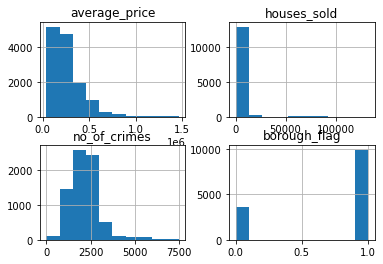

In [7]:
df_monthly.hist();

Average price has the shape we could expect. Lets now work on this specific column to figure its evolution!

## Answering question 1: how does price change over time?

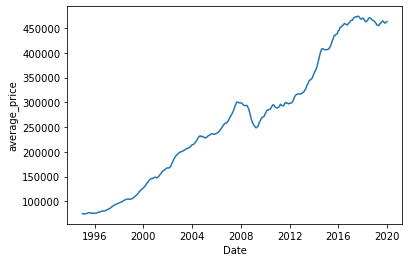

In [8]:
# We chart it for the whole London and by area too
monthly_avg = df_monthly.groupby(['date']).mean()
monthly_avg['Date'] = pd.to_datetime(monthly_avg.index)

sns.lineplot( data = monthly_avg, x='Date', y='average_price');


We notice the upward trend on market price on average, with exception of 2008 (Great Financial Crisis) and more recently some stagnation, probably because affordability is becoming a problem (housing bubble ?)
We now want to check if this trend is everywhere the same in London

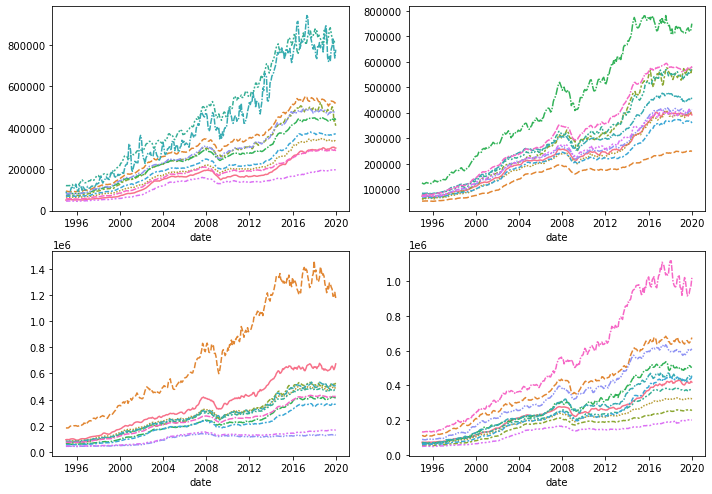

In [9]:
avg_price_area = pd.pivot_table(df_monthly, values='average_price', index=['date'],
                    columns=['area'], aggfunc=np.mean)
# ensure proper date format
avg_price_area.index = pd.to_datetime(avg_price_area.index)

# To improve visualization we split in 4 the charts
nb_areas = avg_price_area.columns.size
nb_lines = int(nb_areas/4)

fig, ax = plt.subplots(2,2, figsize=(11.7, 8.27))

ax1 = sns.lineplot(data = avg_price_area.iloc[:, 0:nb_lines], ax=ax[0,0] );
ax2 = sns.lineplot(data = avg_price_area.iloc[:, nb_lines:2*nb_lines], ax=ax[0,1] );
ax3 = sns.lineplot(data = avg_price_area.iloc[:, 2*nb_lines:3*nb_lines], ax=ax[1,0] );
ax4 = sns.lineplot(data = avg_price_area.iloc[:, 3*nb_lines:-1], ax=ax[1,1] );

# remove legend for readability
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

plt.show()


From the charts above we can draw few conclusions:
1 - Overall, the upward trend is consistent accross all areas.
2 - The dispersion of average price among the different areas is quite important from less than 100k for thew lowest to 1.2m for the highest area.
So we are now exploring question 2 : what explains those differences of price!

## QUESTION 2: What explain differences of prices across the City ?

In [10]:
# We build a dataframe comprise of all the data (monthly and yearly)
# To do that we add all the fields of the yearly dataframe into the monthly one,
# using 2 keys to join them: the year and the area.

# We create Year_Area column in both df
df_monthly['year_area'] = df_monthly['date'].str[:4] + '_' + df_monthly['area']
df_yearly['year_area'] = df_yearly['date'].str[:4] + '_' + df_yearly['area']

# Then we merge the two datasets on the 'year_area' key
df = pd.merge(df_monthly, df_yearly, how="left", on=["year_area"])
df.head()


,date_x,area_x,average_price,code_x,houses_sold,no_of_crimes,borough_flag_x,year_area,code_y,area_y,date_y,median_salary,life_satisfaction,mean_salary,recycling_pct,population_size,number_of_jobs,area_size,no_of_houses,borough_flag_y
0,1995-01-01,city of london,91449,E09000001,17.0,NaN,1,1995_city of london,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1995-02-01,city of london,82203,E09000001,7.0,NaN,1,1995_city of london,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1995-03-01,city of london,79121,E09000001,14.0,NaN,1,1995_city of london,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1995-04-01,city of london,77101,E09000001,7.0,NaN,1,1995_city of london,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1995-05-01,city of london,84409,E09000001,10.0,NaN,1,1995_city of london,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


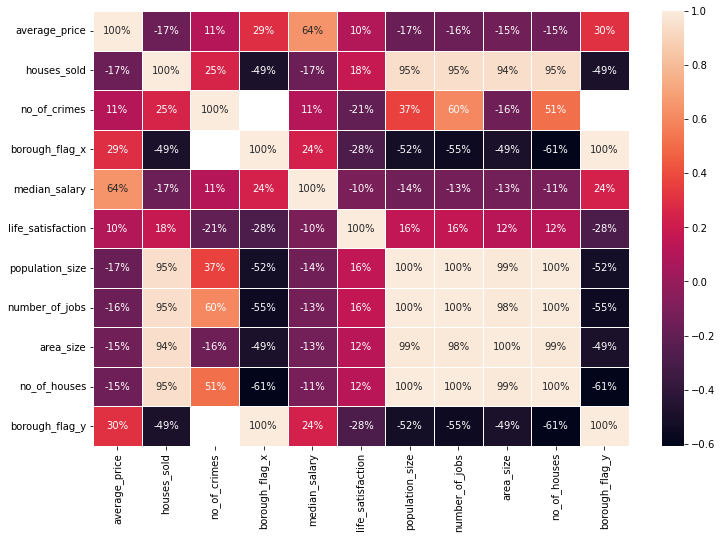

In [11]:
# First we run a correlation matrix to assess relationship between all variables
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".0%", linewidths=.5, ax=ax);

We notice:
- the high correlation between price and salary, which makes sense as one need a high salary to pay for a high price.
- Also the borough_flag shows promising relationship: we expect the borough to be more expensive than outside the city.
- Area size is negatively correlated to the housing price.: this also makes sense as the less room there is the more expensive it is to get a square meter, all things being equal.
- Interestingly, life satisfation correlation to average price (10%) is not very high: money does not necessarily mean happiness after all!

In [12]:
# Before unning some linear regression to forecast the average_price, we clean the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13549 entries, 0 to 13548
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_x             13549 non-null  object 
 1   area_x             13549 non-null  object 
 2   average_price      13549 non-null  int64  
 3   code_x             13549 non-null  object 
 4   houses_sold        13455 non-null  float64
 5   no_of_crimes       7439 non-null   float64
 6   borough_flag_x     13549 non-null  int64  
 7   year_area          13549 non-null  object 
 8   code_y             10836 non-null  object 
 9   area_y             10836 non-null  object 
 10  date_y             10836 non-null  object 
 11  median_salary      10572 non-null  float64
 12  life_satisfaction  3840 non-null   float64
 13  mean_salary        10836 non-null  object 
 14  recycling_pct      9840 non-null   object 
 15  population_size    10320 non-null  float64
 16  number_of_jobs     934

In [13]:
# Some cleaning
# mean_salary should be a float, we check
df.mean_salary.unique()

array([nan, '48922', '52203', '62819', '56450', '64272', '66628', '74004',
       '85886', '86778', '82973', '80769', '81938', '90842', '86987',
       '83403', '82808', '77754', '79489', '80655', '90028', '88342',
       '23620', '24696', '26050', '26653', '27792', '29088', '28728',
       '28660', '31994', '31795', '33126', '32996', '33568', '37059',
       '37214', '36323', '36705', '37959', '32093', '32671', '32010',
       '23128', '25755', '26068', '30210', '30518', '30795', '31652',
       '30923', '33007', '34468', '35013', '34077', '33062', '33044',
       '33766', '34936', '34730', '35315', '36818', '36776', '37328',
       '21386', '22580', '23559', '23517', '24723', '24617', '28162',
       '28847', '30375', '31305', '31988', '30821', '31812', '30833',
       '32463', '31878', '33367', '32666', '33857', '34496', '33978',
       '20911', '23726', '24164', '24071', '29790', '25416', '27371',
       '29712', '28503', '29631', '31033', '29353', '29609', '32089',
       '34480',

In [14]:
# cleaning it
df.mean_salary = df.mean_salary.replace("#", np.nan)
df.mean_salary = df.mean_salary.replace("-", np.nan)
df.mean_salary = df.mean_salary.astype('float64')

In [15]:
df.describe()

,average_price,houses_sold,no_of_crimes,borough_flag_x,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,borough_flag_y
count,1.354900e+04,13455.000000,7439.000000,13549.000000,10572.000000,3840.000000,10632.000000,1.032000e+04,9.348000e+03,7.992000e+03,7.992000e+03,10836.000000
mean,2.635197e+05,3893.994129,2158.352063,0.733338,28789.284904,7.469156,35636.990971,2.542412e+06,1.318031e+06,3.724903e+05,8.814682e+05,0.767442
std,1.876175e+05,12114.402476,902.087742,0.442230,6504.934882,0.196178,11454.513311,8.003419e+06,4.280490e+06,2.155575e+06,3.687835e+06,0.422482
min,4.072200e+04,2.000000,0.000000,0.000000,15684.000000,7.000000,18351.000000,6.581000e+03,4.700000e+04,3.150000e+02,5.009000e+03,0.000000
25%,1.323800e+05,247.000000,1623.000000,0.000000,24582.000000,7.337500,29088.000000,2.158998e+05,8.700000e+04,2.960000e+03,8.761100e+04,1.000000
50%,2.229190e+05,371.000000,2132.000000,1.000000,28284.000000,7.490000,33047.000000,2.688895e+05,1.370000e+05,4.323000e+03,1.024020e+05,1.000000
75%,3.368430e+05,3146.000000,2582.000000,1.000000,31589.000000,7.612500,38614.000000,3.594522e+05,3.390000e+05,8.220000e+03,1.263810e+05,1.000000
max,1.463378e+06,132163.000000,7461.000000,1.000000,61636.000000,7.960000,90842.000000,5.597718e+07,3.049300e+07,1.330373e+07,2.417217e+07,1.000000


In [16]:
# NaN management: we notice few life_satisfaction samples (3840) compared to overall data (13'549),
# We decide to exclude it from the regression. We could also replace by mean or mode of the area for example.
# for area_size we can simply use the median for each area.
median_values = df.groupby('area_x')['area_size'].transform('median')
df['area_size'] = df['area_size'].fillna(median_values)

# For other fields, we simply drop NaN
df.dropna(axis=0, how='all', inplace = True)
df.dropna(subset=['average_price','houses_sold','no_of_crimes','borough_flag_x','median_salary',
                 'mean_salary','population_size','number_of_jobs','no_of_houses']
          , how='any', inplace = True)

df.describe()

,average_price,houses_sold,no_of_crimes,borough_flag_x,median_salary,life_satisfaction,mean_salary,population_size,number_of_jobs,area_size,no_of_houses,borough_flag_y
count,6.867000e+03,6867.000000,6867.000000,6867.0,6867.000000,2988.000000,6867.000000,6867.000000,6867.000000,6867.000000,6867.000000,6867.0
mean,3.404785e+05,312.588321,2148.352410,1.0,29797.670162,7.436988,36612.418523,247107.473132,150221.057230,4879.608126,101814.924858,1.0
std,1.853336e+05,140.650059,895.961932,0.0,5363.898627,0.198382,10346.186203,62961.921462,115886.019589,3195.868997,23768.334804,0.0
min,8.234300e+04,2.000000,0.000000,1.0,15684.000000,7.000000,19520.000000,7115.000000,47000.000000,315.000000,5009.000000,1.0
25%,2.230355e+05,213.000000,1620.000000,1.0,26549.000000,7.300000,30752.000000,205029.000000,83000.000000,2725.000000,85984.000000,1.0
50%,2.888900e+05,289.000000,2125.000000,1.0,29353.000000,7.450000,33688.000000,247614.000000,123000.000000,3857.000000,100471.000000,1.0
75%,4.035335e+05,397.000000,2569.000000,1.0,32143.000000,7.570000,39670.000000,292690.000000,159000.000000,5659.000000,118318.000000,1.0
max,1.463378e+06,963.000000,7076.000000,1.0,52271.000000,7.960000,86778.000000,392140.000000,775000.000000,15013.000000,159470.000000,1.0


In [17]:
# we also put proper date format for date_x as we anticipate that the date will be a key factor to the price,
# as shown in Question1
df['date_x'] = pd.to_datetime(df['date_x'])
df['date'] = df['date_x'].dt.year
df['date'].head()

72    2001
73    2001
74    2001
75    2001
76    2001
Name: date, dtype: int64

In [18]:
# We drop unecessary columns (because same value everywhere)
df.drop(columns = ['borough_flag_x','borough_flag_y'], inplace = True)

We notice now all data are in the borough, so we can drop this variable for the time being. We might consider in the future to focus on that specific variable

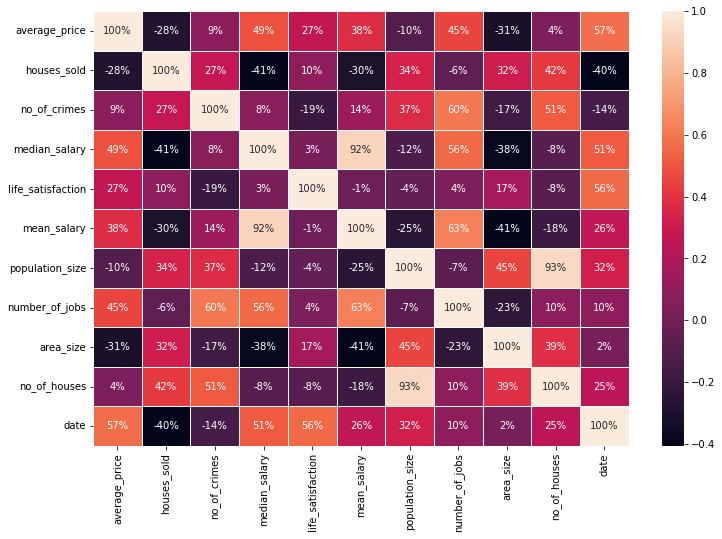

In [19]:
# We re run the correlation
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".0%", linewidths=.5, ax=ax);

In [20]:
# We run a linear regression to find a proper model to forecast price.
# As explanatory variables we keep only interesting ones
X = df[['area_x','houses_sold', 'no_of_crimes', 'median_salary', 'mean_salary',
        'population_size','number_of_jobs','date']]

# we tokenize the area_x to use it in the regression
X = pd.get_dummies(X, columns=['area_x'])

y = df['average_price']

In [21]:
# Build a regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
lm_model = LinearRegression(normalize=True) 
lm_model.fit(X_train, y_train) 


LinearRegression(normalize=True)

In [22]:
# Assess how good is the model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
r2_test = r2_score(y_test,y_test_preds)
r2_train = r2_score(y_train,y_train_preds)
print('r2_train:' + str(r2_train,))
print('r2_test:' + str(r2_test))

r2_train:0.931117896176218
r2_test:0.9309190935361888


In [23]:
# Now we look at the model to understand : how good is the fit and what are the most influencial variables
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = lm_model.coef_
coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df

,est_int,coefs,abs_coefs
13,area_x_city of london,-2.821791e+16,2.821791e+16
39,area_x_westminster,-2.821791e+16,2.821791e+16
12,area_x_camden,-2.821791e+16,2.821791e+16
27,area_x_kingston upon thames,-2.821791e+16,2.821791e+16
7,area_x_barking and dagenham,-2.821791e+16,2.821791e+16
35,area_x_sutton,-2.821791e+16,2.821791e+16
25,area_x_islington,-2.821791e+16,2.821791e+16
36,area_x_tower hamlets,-2.821791e+16,2.821791e+16
23,area_x_hillingdon,-2.821791e+16,2.821791e+16
30,area_x_merton,-2.821791e+16,2.821791e+16


Our model is doing a great job at forecasting housing prices. It is no surprise to see that area is the key variable to assess the housing price. The date is the second most relevant factor as the upward trend of prices in housing was seen in question 1.
This conclude our Question 2 exploration: choose wisely your area, or you might pay a high price for your house!

## QUESTION 3: Where is the best place to live in London, for each budget ?

To answer this question, we will focus compare satisfaction and price for each area to assess where is the best compromise.

In [24]:
#First we rebuild the merger of monthly and yearly and focus only on the columns we are interested in
df_monthly['year_area'] = df_monthly['date'].str[:4] + '_' + df_monthly['area']
df_yearly['year_area'] = df_yearly['date'].str[:4] + '_' + df_yearly['area']

# Then we merge the two datasets on the 'year_area' key
df = pd.merge(df_monthly, df_yearly, how="left", on=["year_area"])

df_q3 = df[['date_x','average_price','area_x','life_satisfaction']]

df_q3.head()

,date_x,average_price,area_x,life_satisfaction
0,1995-01-01,91449,city of london,NaN
1,1995-02-01,82203,city of london,NaN
2,1995-03-01,79121,city of london,NaN
3,1995-04-01,77101,city of london,NaN
4,1995-05-01,84409,city of london,NaN


In [25]:
# we drop all NaN
df_q3.dropna(inplace=True);
df_q3.shape

C:\Users\User\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(3840, 4)

In [26]:
# Now for area we measure average price and satisfaction
area_avg_price = df_q3.groupby('area_x')['average_price'].transform('mean')
area_avg_satisfaction = df_q3.groupby('area_x')['life_satisfaction'].transform('mean')

avg_price_area = pd.pivot_table(df_monthly, values='average_price', index=['date'],
                    columns=['area'], aggfunc=np.mean)
# ensure proper date format
avg_price_area.index = pd.to_datetime(avg_price_area.index)


In [27]:
df_area = df_q3.groupby('area_x').mean()
df_area.reset_index(inplace=True)
df_area.head()

,area_x,average_price,life_satisfaction
0,barking and dagenham,224318.281250,7.32500
1,barnet,447364.281250,7.47875
2,bexley,266902.406250,7.43375
3,brent,407298.833333,7.47000
4,bromley,362468.062500,7.54500


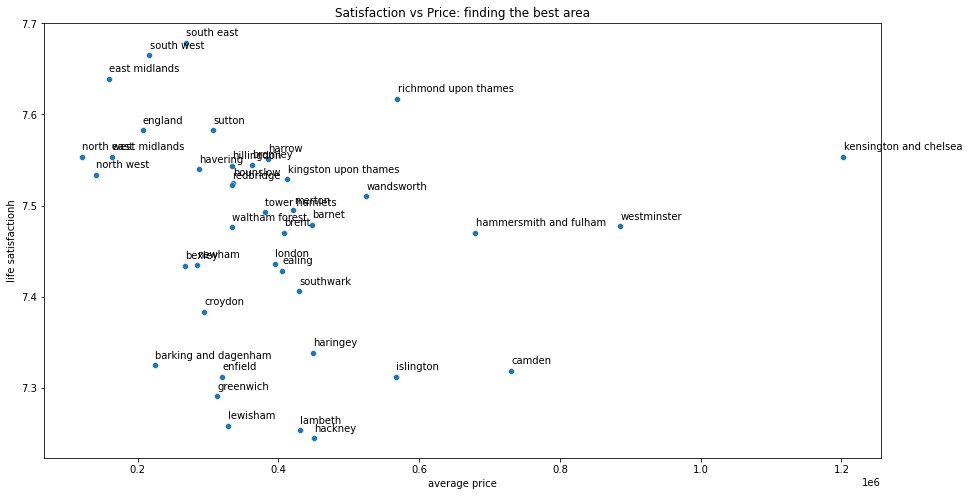

In [28]:
# Plot the result
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data = df_area,  x="average_price", y="life_satisfaction");

plt.title('Satisfaction vs Price: finding the best area')
# Set x-axis label
plt.xlabel('average price')
# Set y-axis label
plt.ylabel('life satisfactionh')

# We are adding name of the areas directly on the chart
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']*1.001, point['y']*1.001, str(point['val']))

label_point(df_area.average_price, df_area.life_satisfaction, df_area.area_x, plt.gca())


We can conclude that you can have a nice life living in East Midlands, South West and South East, while paying less than the average for your house !